# Задание методы защиты в кредитно-финансовой сфере

## Таска
1. Необходимо провести анализ набора данных, рассказать, как он собран и для чего
2. Сформулировать бизнес-задачу (должна быть связана с выявлением мошенничества), указать целевую переменную, выбрать признаки
3. Подготовить наборы данных для применения методов машинного обучения
4. Обучить модель. При этом необходимо использовать тот материал, которых мы проходили на индивидуальных семинарах. Не запрещается использовать и другие подходы, но по ним лучше дать теоретическую справку.
5. Подготовить презентацию и рассказать на семинаре результаты и проблемы, возникшие при моделировании.

### Данные
- [датасет тут](https://www.kaggle.com/datasets/nezukokamaado/auto-loan-dataset)

In [2]:
import pandas as pd
import numpy as np

from google.colab import drive

df = pd.read_csv("financial_loan.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,12-12-2021,09-01-2021,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,12-12-2021,12-03-2021,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835


In [3]:
df.columns

Index(['id', 'address_state', 'application_type', 'emp_length', 'emp_title',
       'grade', 'home_ownership', 'issue_date', 'last_credit_pull_date',
       'last_payment_date', 'loan_status', 'next_payment_date', 'member_id',
       'purpose', 'sub_grade', 'term', 'verification_status', 'annual_income',
       'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc',
       'total_payment'],
      dtype='object')

## Описание колонок
### Идентификаторы
- `id` - уникальный идентификатор кредитной заявки
- `member_id` - идентификатор заемщика
### Адрес и должность
- `adress_state` - штат проживания заемщика
- `emp_title` — должность / профессия
- `emp_length` — стаж работы (в годах, категориальный)
- `home_ownership` — тип владения жильем
### Параметры кредита
- `loan_amount` — сумма кредита
- `term` — срок кредита в месяцах
- `int_rate` — процентная ставка
- `installment` — ежемесячный платеж
- `purpose` — цель кредита
- `grade` — кредитный рейтинг (A–G)
- `sub_grade` — уточненный рейтинг (A1–G5)
### Финансовое состояние
- `annual_income` — годовой доход заемщика
- `dti` — доля долговых обязательств к доходу
- `total_acc` — общее количество кредитных счетов
### Статусы и даты
- `loan_status` — статус кредита (таргет)
- `issue_date` — дата выдачи кредита
- `last_payment_date` — дата последнего платежа
- `next_payment_date` — дата следующего платежа
- `last_credit_pull_date` — дата последней проверки кредитной истории
### Проверки и верификация
- `verification_status` — был ли доход подтвержден
- `application_type` — тип заявки (individual / joint)
### Результат по кредиту
- `total_payment` - общая сумма, выплаченная по кредиту
## Заметки
`loan_status` - целевая фича
Может использоваться напрямую (дефолт / не дефолт) или как proxy для мошенничества. Есть поведенчские признаки, финансовые признаки, временные признаки (возможен лик)

# EDA начинается здесь
 - анализ данных
 - очистка датасета, подготовка к обучению

# 1. Анализ набора данных

## Как собран датасет
Датасет - исторические данные по автокредитам, выданным финансовым учреждением. \
Содержит информацию о:
- Заёмщиках (демография, доход, занятость, кредитная история)
- Условиях кредита (сумма, срок, процентная ставка, платежи)
- Истории обслуживания (даты платежей, текущий статус)

## Временной период
Данные охватывают 2021-2022 годы (формат ДД-ММ-ГГГГ).

## Источник данных
Датасет представляет собой обезличенные исторические данные кредитных заявок, опубликованные на Kaggle. Предположительно отражает данные реального кредитного учреждения.

## Цель сбора
- Отслеживание кредитного портфеля
- Анализ эффективности кредитной политики
- Мониторинг рисков и дефолтов

# 2. Бизнес-задача

Финансовые потери из-за кредитов, выданных заемщикам с искажённой или недостоверной информацией, что повышает вероятность дефолта.

#### Конкретная задача
Разработка модели для раннего выявления потенциально мошеннических заявок на этапе рассмотрения



# 3. EDA

In [4]:
print("Размер данных:", df.shape)

Размер данных: (38576, 24)


### Типы признаков

In [5]:
df.dtypes.reset_index().rename(columns={"index":"feature", 0:"dtype"})

,feature,dtype
0,id,int64
1,address_state,object
2,application_type,object
3,emp_length,object
4,emp_title,object
5,grade,object
6,home_ownership,object
7,issue_date,object
8,last_credit_pull_date,object
9,last_payment_date,object


### Количетсво пропусков и уникальных значений

In [6]:
info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing": df.isna().sum(),
    "missing_%": (df.isna().mean()*100).round(2),
    "n_unique": df.nunique(dropna=False),
}).sort_values("missing_%", ascending=False)

info

,dtype,missing,missing_%,n_unique
emp_title,object,1438,3.73,28526
id,int64,0,0.00,38576
application_type,object,0,0.00,1
address_state,object,0,0.00,50
emp_length,object,0,0.00,11
grade,object,0,0.00,7
home_ownership,object,0,0.00,5
issue_date,object,0,0.00,65
last_credit_pull_date,object,0,0.00,107
last_payment_date,object,0,0.00,102


- пропуски почти отсутствуют, заметно только emp_title ~3.73%;
- emp_title имеет очень много уникальных значений (десятки тысяч). Его нельзя просто one-hot’нуть;
- application_type константный => можно смело удалять;
- если прогноз на момент выдачи, то убираем всё, что появляется после выдачи кредита (total_payment, last_payment_date, next_payment_date, last_credit_pull_dat);
- при временных данных нельзя ограничиваться train/test-разбиением, будем использовать out-of-time сплит;
- можно спокойно удалить следующие неинформативные столбцы: id, member_id.

### Анализ таргета

In [7]:
df["loan_status"].value_counts(dropna=False)

,count
loan_status,
Fully Paid,32145
Charged Off,5333
Current,1098


In [8]:
df_bin = df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()
df_bin["y"] = (df_bin["loan_status"] == "Charged Off").astype(int)
df_bin["y"].value_counts(normalize=True)

,proportion
y,
0,0.857703
1,0.142297


- у loan_status оставить только Fully Paid и Charged Off, а Current лучше исключить, потому что это «недонаблюдённый» статус;
- наблюдается дисбаланс классов: дефолтов ~14%;

### Построим графики распределения по времени
Дропаем ненужные столбцы и преобразуем даты, пока уберем emp_title из-за пропусков и большого разнообразия


In [9]:
# 1. Преобразуем даты и посмотрим диапазон
df_bin['issue_date_dt'] = pd.to_datetime(df_bin['issue_date'], format='%d-%m-%Y')
print(f"Датасет охватывает период с {df_bin['issue_date_dt'].min()} по {df_bin['issue_date_dt'].max()}")

# 2. Удаляем ненужные столбцы (согласно пункту 2)
cols_to_drop = ['member_id', 'id', 'total_payment', 'last_payment_date',
                'next_payment_date', 'last_credit_pull_date', 'application_type', 'emp_title']
df_cleaned = df_bin.drop(columns=cols_to_drop)


Датасет охватывает период с 2021-01-01 00:00:00 по 2021-12-12 00:00:00


70% самых ранних данных - train

15% следующих - validation

15% самых поздних - test

/tmp/ipython-input-1250742682.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df_cleaned.set_index('issue_date_dt').resample('M').size()
/tmp/ipython-input-1250742682.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_defaults = df_cleaned.set_index('issue_date_dt').resample('M')['y'].mean()


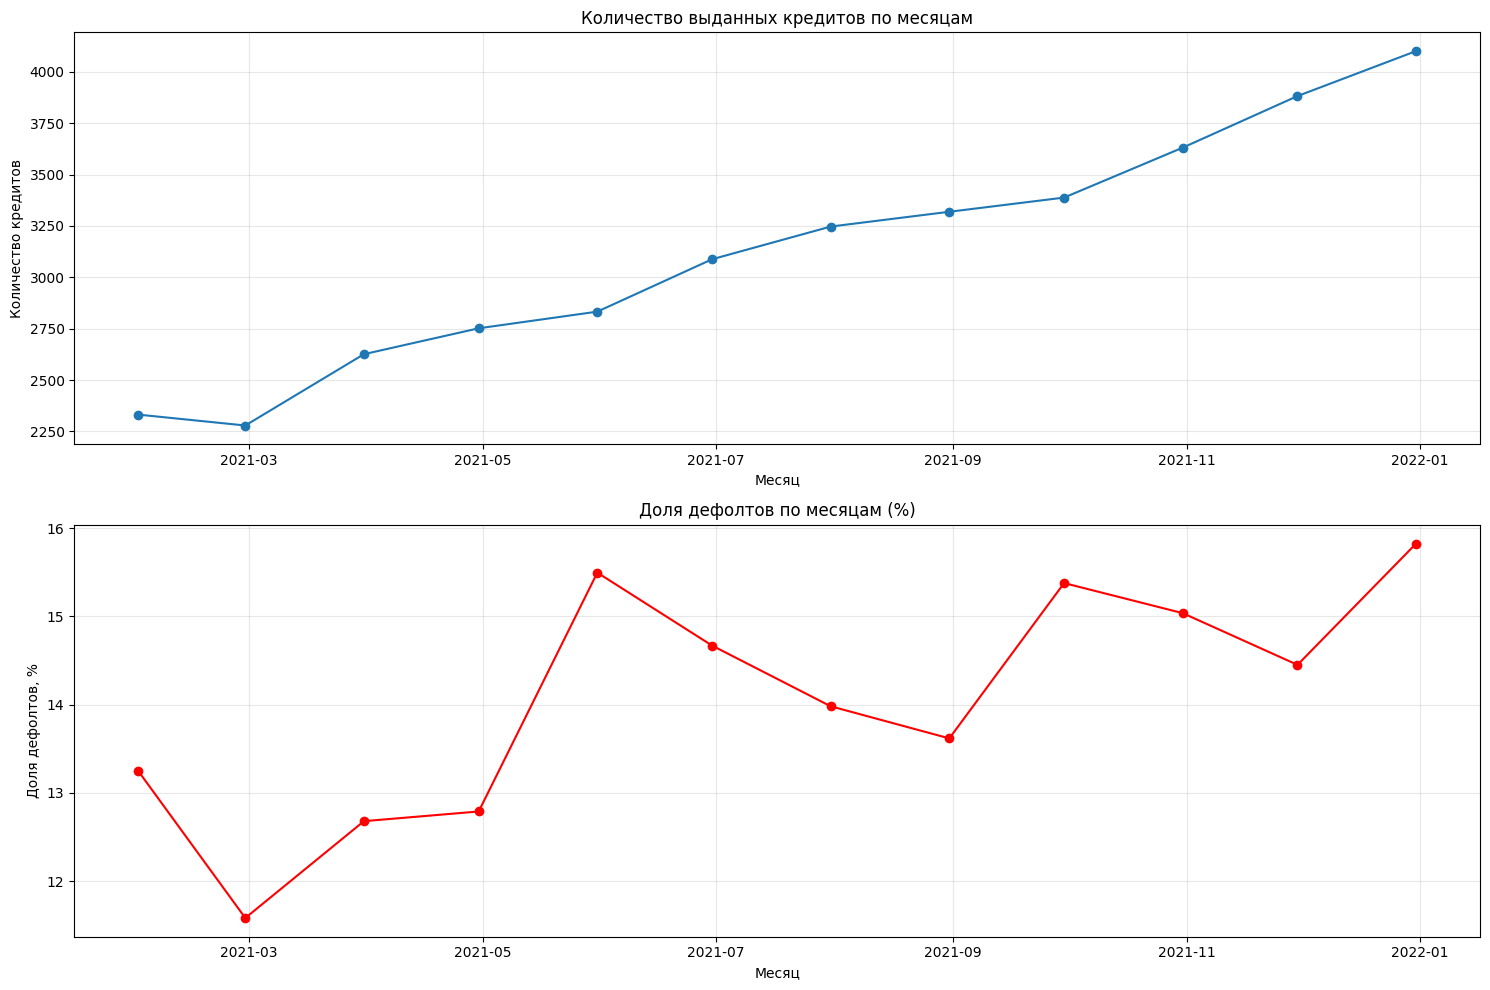


=== Статистика по месяцам ===
               count  default_rate
issue_date_dt                     
2021-03-31      2626      0.126809
2021-04-30      2752      0.127907
2021-05-31      2833      0.154959
2021-06-30      3088      0.146697
2021-07-31      3247      0.139821
2021-08-31      3319      0.136186
2021-09-30      3388      0.153778
2021-10-31      3631      0.150372
2021-11-30      3882      0.144513
2021-12-31      4101      0.158254

=== Разделение данных ===
Train: 26234 записей (2021-01-01 00:00:00 - 2021-10-09 00:00:00)
Val:   5622 записей (2021-10-09 00:00:00 - 2021-11-11 00:00:00)
Test:  5622 записей (2021-11-11 00:00:00 - 2021-12-12 00:00:00)

Доля дефолтов в train: 13.845%
Доля дефолтов в val:   15.155%
Доля дефолтов в test:  15.101%


/tmp/ipython-input-1250742682.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df_cleaned.set_index('issue_date_dt').resample('M').agg({


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# График 1: Количество кредитов по месяцам
monthly_counts = df_cleaned.set_index('issue_date_dt').resample('M').size()
axes[0].plot(monthly_counts.index, monthly_counts.values, marker='o')
axes[0].set_title('Количество выданных кредитов по месяцам')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество кредитов')
axes[0].grid(True, alpha=0.3)

# График 2: Доля дефолтов по месяцам
monthly_defaults = df_cleaned.set_index('issue_date_dt').resample('M')['y'].mean()
axes[1].plot(monthly_defaults.index, monthly_defaults.values * 100, marker='o', color='red')
axes[1].set_title('Доля дефолтов по месяцам (%)')
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Доля дефолтов, %')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Анализ для разделения данных
print("\n=== Статистика по месяцам ===")
monthly_stats = df_cleaned.set_index('issue_date_dt').resample('M').agg({
    'y': ['count', 'mean']
})
monthly_stats.columns = ['count', 'default_rate']
print(monthly_stats.tail(10))

# 5. Определение точек разделения
# Разделим по времени: train 70%, val 15%, test 15%
df_sorted = df_cleaned.sort_values('issue_date_dt')
total = len(df_sorted)
train_end_idx = int(total * 0.7)
val_end_idx = int(total * 0.85)

train_df = df_sorted.iloc[:train_end_idx]
val_df = df_sorted.iloc[train_end_idx:val_end_idx]
test_df = df_sorted.iloc[val_end_idx:]

print(f"\n=== Разделение данных ===")
print(f"Train: {len(train_df)} записей ({train_df['issue_date_dt'].min()} - {train_df['issue_date_dt'].max()})")
print(f"Val:   {len(val_df)} записей ({val_df['issue_date_dt'].min()} - {val_df['issue_date_dt'].max()})")
print(f"Test:  {len(test_df)} записей ({test_df['issue_date_dt'].min()} - {test_df['issue_date_dt'].max()})")

print(f"\nДоля дефолтов в train: {train_df['y'].mean():.3%}")
print(f"Доля дефолтов в val:   {val_df['y'].mean():.3%}")
print(f"Доля дефолтов в test:  {test_df['y'].mean():.3%}")

In [16]:
# Сначала создаем месяц из даты
df_cleaned['issue_month'] = df_cleaned['issue_date_dt'].dt.month

# Теперь группируем по месяцам
top_default_months = df_cleaned.groupby('issue_month')['y'].mean().sort_values(ascending=False)
print(top_default_months)

issue_month
12    0.158254
5     0.154959
9     0.153778
10    0.150372
6     0.146697
11    0.144513
7     0.139821
8     0.136186
1     0.132504
4     0.127907
3     0.126809
2     0.115840
Name: y, dtype: float64


Сезонность слабая - колебания в пределах статистической погрешности
Декабрь самый рискованный (+3-4% к среднему), (возможно новогодние траты)

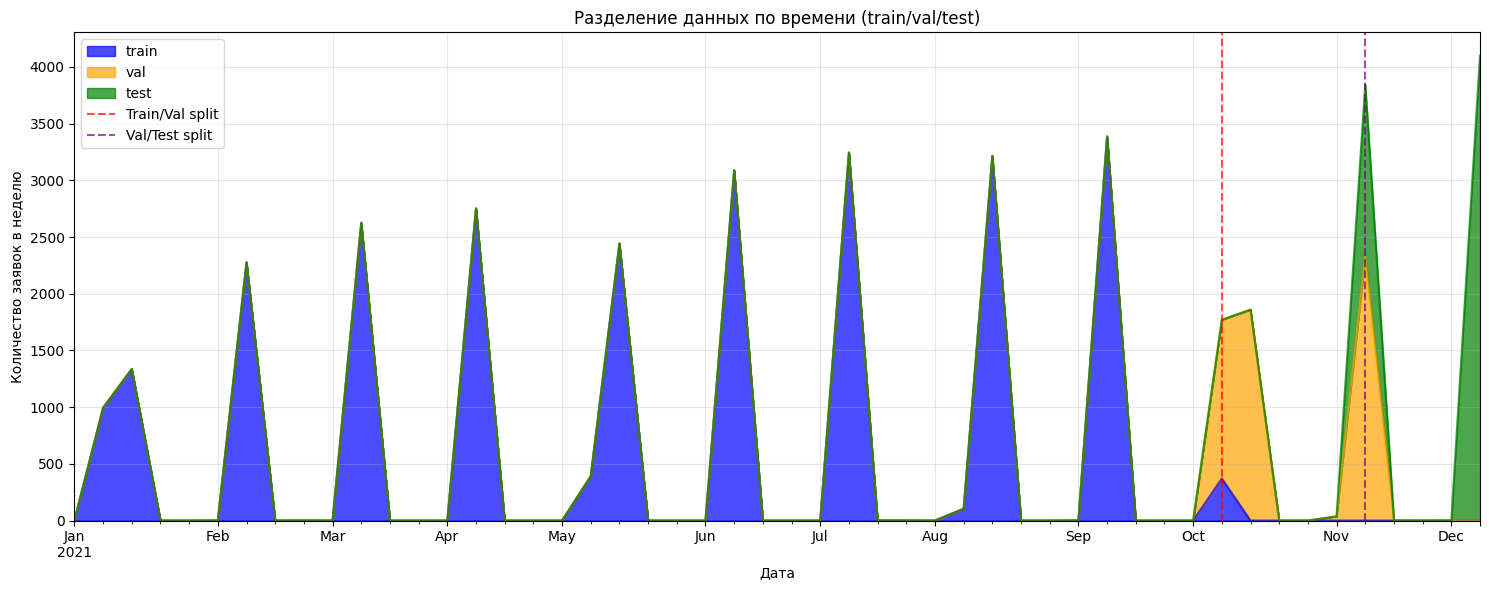


=== Сохранение очищенных данных ===
Данные сохранены в 'cleaned_loan_data.csv'


In [11]:
# Визуализация разделения данных
fig, ax = plt.subplots(figsize=(15, 6))

# Создаем временной ряд с метками разделов
df_sorted['split'] = 'train'
df_sorted.iloc[train_end_idx:val_end_idx, df_sorted.columns.get_loc('split')] = 'val'
df_sorted.iloc[val_end_idx:, df_sorted.columns.get_loc('split')] = 'test'

# Подсчет по неделям для наглядности
weekly_counts = df_sorted.set_index('issue_date_dt').resample('W')['split'].apply(
    lambda x: x.value_counts().to_dict()
).unstack().fillna(0)

weekly_counts[['train', 'val', 'test']].plot(kind='area', stacked=True, ax=ax,
                                            color=['blue', 'orange', 'green'], alpha=0.7)

# Вертикальные линии разделов
train_end_date = df_sorted.iloc[train_end_idx]['issue_date_dt']
val_end_date = df_sorted.iloc[val_end_idx]['issue_date_dt']

ax.axvline(x=train_end_date, color='red', linestyle='--', alpha=0.7, label='Train/Val split')
ax.axvline(x=val_end_date, color='purple', linestyle='--', alpha=0.7, label='Val/Test split')

ax.set_title('Разделение данных по времени (train/val/test)')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заявок в неделю')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сохраняем очищенные данные
print("\n=== Сохранение очищенных данных ===")
df_cleaned.to_csv('cleaned_loan_data.csv', index=False)
print("Данные сохранены в 'cleaned_loan_data.csv'")

# Обучение моделей
- baseline
- анализ ошибок
- исправление ошибок

# План дальнейшего развития
- Выписать идеи по улучшению решения
- Выписать все, что не успели сделать в виду ограничений по времени